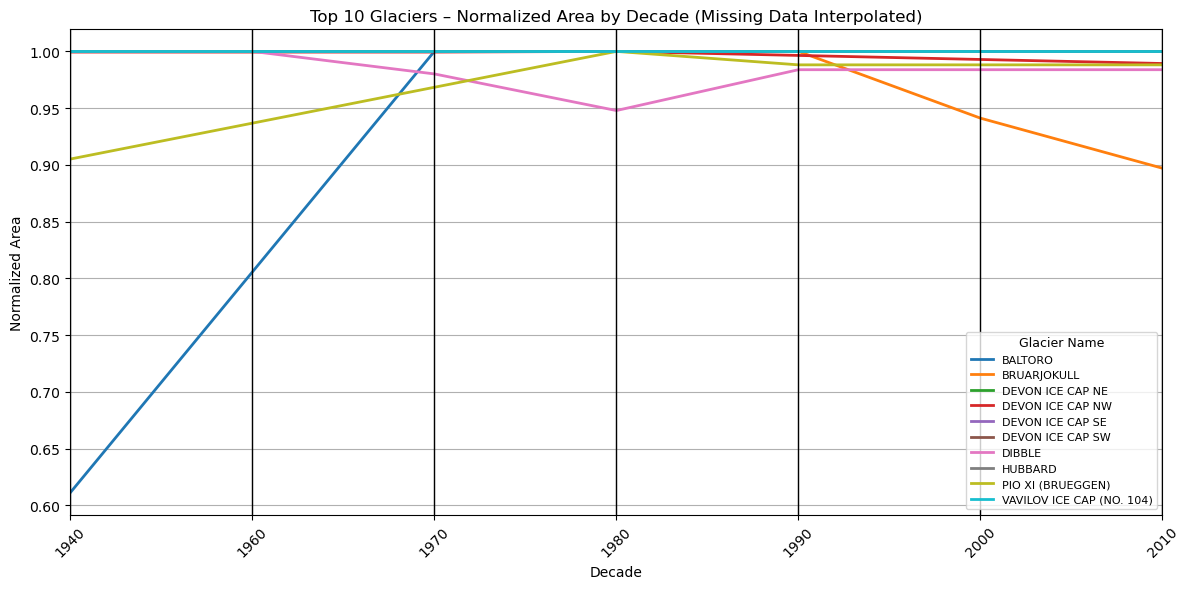

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Load the dataset
file_path = 'state.csv'
df = pd.read_csv(file_path)

# Drop rows with missing crucial values
df = df.dropna(subset=['YEAR', 'AREA', 'NAME'])

# Ensure correct data types
df['YEAR'] = df['YEAR'].astype(int)
df['AREA'] = pd.to_numeric(df['AREA'], errors='coerce')

# Determine top 10 glaciers by most recent AREA
latest_areas = df.sort_values('YEAR').groupby('NAME').last().reset_index()
top10_names = latest_areas.nlargest(10, 'AREA')['NAME']

# Filter for top 10 glaciers
top10_df = df[df['NAME'].isin(top10_names)].copy()

# Add DECADE column
top10_df['DECADE'] = (top10_df['YEAR'] // 10) * 10

# Average AREA per glacier per decade
pivot_df = top10_df.groupby(['NAME', 'DECADE'])['AREA'].mean().reset_index()

# Get the full range of decades
all_decades = sorted(pivot_df['DECADE'].unique())

# Pivot to wide format with all decades
parallel_data = pivot_df.pivot(index='NAME', columns='DECADE', values='AREA').reindex(columns=all_decades).reset_index()

# Option A: Interpolation across decades
parallel_data.iloc[:, 1:] = parallel_data.iloc[:, 1:].interpolate(axis=1, limit_direction='both')

# Normalize rows (each glacier's AREA values are divided by its max area)
parallel_data_norm = parallel_data.copy()
parallel_data_norm.iloc[:, 1:] = parallel_data_norm.iloc[:, 1:].div(parallel_data_norm.iloc[:, 1:].max(axis=1), axis=0)

# Plot if sufficient columns exist
if parallel_data_norm.shape[1] < 3:
    print("Not enough data across decades to create the plot.")
else:
    plt.figure(figsize=(12, 6))
    lines = parallel_coordinates(parallel_data_norm, 'NAME', colormap=plt.cm.tab10, linewidth=2)
    plt.title("Top 10 Glaciers – Normalized Area by Decade (Missing Data Interpolated)")
    plt.ylabel("Normalized Area")
    plt.xlabel("Decade")
    plt.xticks(rotation=45)
    plt.grid(True)

    # Add legend in the bottom right
    plt.legend(loc='lower right', title='Glacier Name', bbox_to_anchor=(1, 0), fontsize=8, title_fontsize=9)

    plt.tight_layout()
    plt.show()